In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [4]:
batch_size = 32
img_height = 180
img_width = 180

dr_tr = 'D:\\Users\\Me\\Programming\\My_Python\\DeepLearning\\Projects\\Chest X-Ray Classification\\chest_xray\\train'
dr_test = 'D:\\Users\\Me\\Programming\\My_Python\\DeepLearning\\Projects\\Chest X-Ray Classification\\chest_xray\\test'
dr_val = 'D:\\Users\\Me\\Programming\\My_Python\\DeepLearning\\Projects\\Chest X-Ray Classification\\chest_xray\\val'

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  dr_tr,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


val_ds = tf.keras.utils.image_dataset_from_directory(
  dr_val,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  dr_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
['NORMAL', 'PNEUMONIA']


In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [27]:
from keras.layers import Conv2D, MaxPooling2D,Dropout, Flatten, Dense, Activation,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 batch_normalization_8 (Batc  (None, 178, 178, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 89, 89, 32)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 batch_normalization_9 (Batc  (None, 87, 87, 64)      

In [29]:
epochs = 10
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]
history = model.fit(train_ds, validation_data=val_ds, callbacks=callbacks, epochs=epochs)

Epoch 1/10
163/163 [==============================] - 218s 1s/step - loss: 0.1517 - accuracy: 0.9415 - val_loss: 36.4949 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 211s 1s/step - loss: 0.1435 - accuracy: 0.9479 - val_loss: 41.9484 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.1595 - accuracy: 0.9400
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
163/163 [==============================] - 213s 1s/step - loss: 0.1595 - accuracy: 0.9400 - val_loss: 9.3195 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 211s 1s/step - loss: 0.1604 - accuracy: 0.9396 - val_loss: 77.4041 - val_accuracy: 0.5000 - lr: 5.0000e-04
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.1421 - accuracy: 0.9482
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
163/163 [===========================

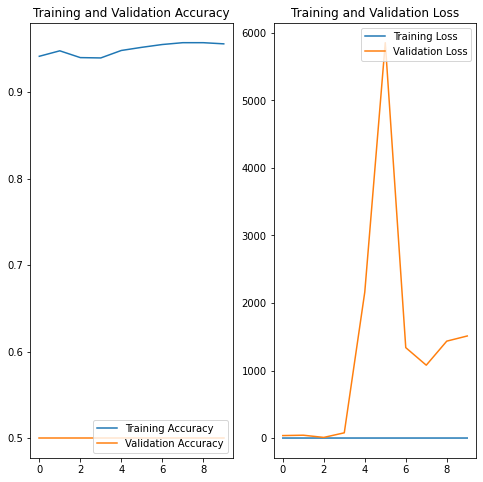

In [30]:
# Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
img_path = '....\\test\\PNEUMONIA\\person1_virus_6.jpeg'
# Actual output - PNeumonia - image from test dataset
img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to PNEUMONIA with a 73.11 percent confidence.
